## Step 0. Folder Structure
```
3. Deep Learning Project/
├── dataset_split/
│   ├── train/
│   │   ├── african_elephant (780 images)
│   │   ├── airliner (780 images)
│   │   └── ... (8 more folders)
│   ├── val/
│   │   ├── african_elephant (260 images)
│   │   ├── airliner (260 images)
│   │   └── ... (8 more folders)
│   └── test (2600 images)
├── data_preprocessed/
│   ├── labels_train.pt
│   ├── labels_val.pt
│   ├── tensor_test.pt
│   ├── tensor_train.pt
│   └── tensor_val.pt
├── models/
│   ├── resnet18_checkpoint.pkl
│   └── resnet34_checkpoint.pkl
├── src/
│   └── part3.ipynb
├── src_datasplit/
│   └── data_split.ipynb
├── MSA.yaml
├── README.md
└── IEEE_Report_Template.docx
```


In [1]:
# TODO: Import the libraries.
from typing import Tuple, List
import os
import cv2
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import copy
import matplotlib.pyplot as plt
import csv
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader


In [2]:
# Set the random seed for reproducibility.
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Step 1 Preprocessing
1. Load images and labels from folders into lists.
2. Resize the images.
3. Convert the image data type as float32 and limit the range in [0, 1].
4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.
5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).
6. Saving the pre-processed sets as .pt files in the correct directory.
7. Load the pre-processed sets from .pt files. 

### - TODO: 1. Load images from folder into a list.

In [3]:
# TODO: 1. Load images from folder into a list.
def image_loader(set_dir: str) -> Tuple[List[np.ndarray], List[str]]:
    """
    Load all images from a dataset directory (train/val/test) into memory.
    Make sure:
        1. Load training and validation set images and labels in the correct order.
        2. Load testing set images in filename order (e.g., 0.jpg, 1.jpg, ...).
    
    Parameters:
    -----------
    set_dir : str
        Path to the directory containing either:
        - Class subdirectories (for train/val sets)
        - Direct image files (for test set)
        
    Returns:
    --------
    Tuple[List[np.ndarray], List[str]]
        images: List of BGR images (HWC format, uint8 dtype)
        labels: List of string labels (empty for test set)
        
    Example:
    --------
    >>> images_train, labels_train = image_loader("../dataset_split/train")
    >>> images_test, _ = image_loader("../dataset_split/test")
    """
    # Initialize lists to hold images and labels
    images = []
    labels = []
    

    is_test_set = True  # Initially assume it's a test set
    
    # Check if the directory contains subdirectories (indicating train/val set)
    for file_name in os.listdir(set_dir):
        file_path = os.path.join(set_dir, file_name)
        if not os.path.isfile(file_path):
            is_test_set = False
            break  # Found a subdirectory, so it's not a test set


    if is_test_set:
        # Test set: load images in filename order
        for filename in sorted(os.listdir(set_dir), key=lambda x: int(x.split('.')[0])):   # Sort by numeric order
            file_path = os.path.join(set_dir, filename)   # File path to the image
            image = cv2.imread(file_path)
            if image is not None:
                images.append(image)
        labels = []  # Test set has no labels, so we return an empty list
    else:
        # Train/Val set: load images and labels from class subdirectories
        class_dirs = sorted(os.listdir(set_dir))
        for class_dir in class_dirs:     # Iterate through each class directory
            class_path = os.path.join(set_dir, class_dir)
            for filename in sorted(os.listdir(class_path)):   # Iterate each file in the class directory
                file_path = os.path.join(class_path, filename)
                image = cv2.imread(file_path)
                if image is not None:
                    images.append(image)
                    labels.append(class_dir)

    # Return the loaded images and labels           
    return images, labels



### - TODO: 2. Resize images.

In [4]:
# TODO: 2. Resize images.
def img_resize(images: List[np.ndarray], target_size: int = 224) -> np.ndarray:
    """
    Resize images with the shortest edge to target_size and perform center cropping to square dimensions.
    
    Args:
        images: List of input images in BGR format (OpenCV default) with shape (H, W, C)
        target_size: Desired output size (both width and height after cropping). Default 224.
        
    Returns:
        Stacked numpy array of processed images with shape (N, target_size, target_size, 3)
        where N is the number of input images
        
    Raises:
        ValueError: If input images have inconsistent channels or invalid dimensions
        
    Notes:
        - Preserves original aspect ratio during resizing
        - Performs center cropping to exact square dimensions
        - Maintains uint8 dtype unless conversion forces float32
        
    Example:
        >>> imgs = [cv2.imread('test.jpg')]  # List of BGR images
        >>> processed = img_resize(imgs)
        >>> processed.shape  # (1, 224, 224, 3)
    """
    
    # Check if images list is empty 
    if not images:
        return np.array([])

    # Initialize list to hold processed images
    processed_images = []

    # Iterate through each image
    for image in images:
        # Check if the image is valid
        if image is None or len(image.shape) != 3 or image.shape[2] != 3:
            raise ValueError("Invalid image dimensions or inconsistent channels")  # Error if image is not a valid BGR image
        
        # Get original dimensions
        h, w, c = image.shape

        # Resize the image while maintaining aspect ratio
        scale = target_size / min(h, w)  # Calculate scale factor based on shortest edge
        new_h, new_w = round(h * scale), round(w * scale)
        resized_image = cv2.resize(image, (new_w, new_h))

        # Center crop to square dimensions
        left = (new_w - target_size) // 2
        top = (new_h - target_size) // 2
        croped_image = resized_image[top:top + target_size, left:left + target_size]

        # Append the processed image to the list
        processed_images.append(croped_image)
        
    return np.stack(processed_images)
    

In [5]:
# Load images

images_train, labels_train = image_loader("../dataset_split/train")
images_val, labels_val = image_loader("../dataset_split/val")
images_test, _ = image_loader("../dataset_split/test")

In [6]:
# Resize the images

images_train = img_resize(images_train, 224)
images_val = img_resize(images_val, 224)
images_test = img_resize(images_test, 224)

### - TODO: 3. Convert the image data type as float32 and limit the range in [0, 1].

In [7]:
# TODO: 3. Convert the image data type as float32 and limit the range in [0, 1].

images_train = images_train.astype(np.float32) / 255.0
images_val = images_val.astype(np.float32) / 255.0
images_test = images_test.astype(np.float32) / 255.0

### - TODO: 4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.

In [8]:
# TODO: 4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.

tensor_train = torch.from_numpy(np.transpose(images_train, (0, 3, 1, 2)))
tensor_val = torch.from_numpy(np.transpose(images_val, (0, 3, 1, 2)))
tensor_test = torch.from_numpy(np.transpose(images_test, (0, 3, 1, 2)))

### - TODO: 5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).

In [9]:
# TODO: 5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).

train_mean = tensor_train.mean(dim=(0, 2, 3), keepdim=True)
train_std = tensor_train.std(dim=(0, 2, 3), keepdim=True)

tensor_train = (tensor_train - train_mean) / train_std
tensor_val = (tensor_val - train_mean) / train_std
tensor_test = (tensor_test - train_mean) / train_std

### - TODO: 6. Save the pre-processed sets as .pt files.

In [10]:
# TODO: 6. Save the pre-processed sets as .pt files.

# 6.1 Save the tensor_train, tensor_val, and tensor_test as tensor_train.pt, tensor_val.pt, and tensor_test.pt, respectively.
torch.save(tensor_train, "../data_preprocessed/tensor_train.pt")
torch.save(tensor_val, "../data_preprocessed/tensor_val.pt")
torch.save(tensor_test, "../data_preprocessed/tensor_test.pt")

# 6.2 Create a list to map index to label and a dictionary to map label to index.
#   For instance:
#       unique_labels = ['african_elephant', 'airliner', ...]
#       label_to_index = {
#           'african_elephant': 0,
#           'airliner': 1,
#           ...
#       }
unique_labels = sorted(list(set(labels_train)))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# 6.3 Map the labels to index.
labels_train_index = np.array([label_to_index[label] for label in labels_train])
labels_val_index = np.array([label_to_index[label] for label in labels_val])

# 6.4 Save the index, label_to_index, and index_to_label.
torch.save(labels_train_index, "../data_preprocessed/labels_train.pt")
torch.save(labels_val_index, "../data_preprocessed/labels_val.pt")
torch.save(label_to_index, "../data_preprocessed/label_to_index.pt")
torch.save(index_to_label, "../data_preprocessed/index_to_label.pt")

### - TODO: 7. Load the pre-processed sets from .pt files. The data can be used directly in future without pre-processing once more by loading from the folder.

In [11]:
# TODO: 7. Load the pre-processed sets from .pt files. The data can be used directly in future without pre-processing once more by loading from the folder.

tensor_train = torch.load("../data_preprocessed/tensor_train.pt")
tensor_val = torch.load("../data_preprocessed/tensor_val.pt")
tensor_test = torch.load("../data_preprocessed/tensor_test.pt")

labels_train_index = torch.load("../data_preprocessed/labels_train.pt")
labels_val_index = torch.load("../data_preprocessed/labels_val.pt")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17240\226906326.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_train = torch.load("../data_preprocessed/tensor_train

# Step 2 Train the teacher model (ResNet34)
1. Set hyperparameters for the training process.
2. Create a pretrained ResNet34.
3. Define the optimizer, loss function, etc.
4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
5. Plot the loss and accuracy curves.

In [12]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

10
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
(7800,)
(2600,)


### - TODO: 1. Set hyperparameters for the training process.

In [13]:
# TODO: 1. Set hyperparameters for the training process.

MAX_EPOCH = 10
INIT_LR = 0.0001
BATCH_SIZE = 64

# Specify the training device (automatically detects GPU if available)
# Usage example: 
#   tensor = tensor.to(device)  # Moves tensor to selected device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### - TODO: 2. Create a pretrained ResNet34.

In [14]:
# TODO: 2. Create a pretrained ResNet34.

# 2.1 Use torchvision to create a pretrained ResNet34.
resnet34 = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.DEFAULT)

# 2.2 Modify the output layer so that the model aligns with this project.
resnet34.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet34.fc.in_features, num_classes)
)
# Freeze the parameters of the pretrained model except for the last fully connected layer.
for param in resnet34.parameters():
    param.requires_grad = False
for param in resnet34.fc.parameters():
    param.requires_grad = True

# 2.2 Move the model to selected device.
resnet34 = resnet34.to(device)

### - TODO: 3. Define the optimizer, loss function, etc.

In [15]:
# TODO: 3. Define the optimizer, loss function, etc.

optimizer = torch.optim.Adam(
    resnet34.fc.parameters(),
    lr= INIT_LR,
    weight_decay=1e-4
)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

### - TODO: 4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.

In [16]:
# TODO: 4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
# Hint: May not need too many epochs as this is a pretrained model.

train_accs_resnet34, train_losses_resnet34, val_accs_resnet34, val_losses_resnet34 = [], [], [], []

# Initialize the best validation accuracy and a copy of the model weights
best_val_acc = 0.0
best_model_wts = copy.deepcopy(resnet34.state_dict())

# Ensure label indices are torch tensors of type long (required for loss function)
labels_train_index = torch.tensor(labels_train_index, dtype=torch.long)
labels_val_index = torch.tensor(labels_val_index, dtype=torch.long)

# Create a TensorDataset and DataLoader for the training set
train_dataset = TensorDataset(tensor_train, labels_train_index)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,      # Shuffle data at every epoch
    num_workers=4,     # Number of subprocesses for data loading
    pin_memory=True    # Pin memory for faster GPU transfer
 )

# Training loop for MAX_EPOCH epochs
for epoch in range(MAX_EPOCH):
    print("-" * 20)
    print(f"Epoch {epoch+1}/{MAX_EPOCH}")
    print("-" * 10)

    # ---------- Train ----------
    resnet34.train()  # Set model to training mode
    train_loss, train_corrects = 0.0, 0

    # Iterate over training batches
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet34(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)  # Accumulate loss
        _, preds = torch.max(outputs, 1)            # Get predicted class indices
        train_corrects += torch.sum(preds == labels).item()  # Count correct predictions

    # Compute average training loss and accuracy for this epoch
    epoch_train_loss = train_loss / len(tensor_train)
    epoch_train_acc = train_corrects / len(tensor_train)

    train_losses_resnet34.append(epoch_train_loss)
    train_accs_resnet34.append(epoch_train_acc)

    # ---------- Validation ----------
    resnet34.eval()  # Set model to evaluation mode (disables dropout, etc.)
    val_loss, val_corrects = 0.0, 0

    all_preds = []
    all_labels = []

    # Evaluate on the validation set without gradient computation
    with torch.no_grad():
        for i in range(0, len(tensor_val), BATCH_SIZE):
            inputs = tensor_val[i:i+BATCH_SIZE].to(device)
            labels = labels_val_index[i:i+BATCH_SIZE].to(device)

            outputs = resnet34(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels)
            
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    # Compute average validation loss and accuracy for this epoch
    epoch_val_loss = val_loss / len(tensor_val)
    epoch_val_acc = val_corrects.double() / len(tensor_val)

    val_losses_resnet34.append(epoch_val_loss)
    val_accs_resnet34.append(epoch_val_acc.item())

    # Print training and validation metrics for this epoch
    print(f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f}")
    print(f"Val   Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")
    


    # ---------- Save Best ----------
    is_better = False
    # Save model if validation accuracy improves, or if accuracy is tied but loss improves
    if epoch_val_acc > best_val_acc:
        is_better = True
    elif epoch_val_acc == best_val_acc and epoch_val_loss < best_val_loss:
        is_better = True

    if is_better:
        best_val_acc = epoch_val_acc
        best_val_loss = epoch_val_loss  
        torch.save(resnet34.state_dict(), "../models/resnet34_checkpoint.pkl")  # Save model weights
        print("--- Best model ---")
        print(f"✅ Best model saved at Epoch {epoch+1} | Val Acc: {epoch_val_acc:.4f} | Val Loss: {epoch_val_loss:.4f}")




--------------------
Epoch 1/10
----------
Train Loss: 2.3277, Acc: 0.2168
Val   Loss: 1.6848, Acc: 0.6435
--- Best model ---
✅ Best model saved at Epoch 1 | Val Acc: 0.6435 | Val Loss: 1.6848
--------------------
Epoch 2/10
----------
Train Loss: 1.5993, Acc: 0.5637
Val   Loss: 1.1563, Acc: 0.9038
--- Best model ---
✅ Best model saved at Epoch 2 | Val Acc: 0.9038 | Val Loss: 1.1563
--------------------
Epoch 3/10
----------
Train Loss: 1.2085, Acc: 0.7704
Val   Loss: 0.9094, Acc: 0.9446
--- Best model ---
✅ Best model saved at Epoch 3 | Val Acc: 0.9446 | Val Loss: 0.9094
--------------------
Epoch 4/10
----------
Train Loss: 1.0135, Acc: 0.8542
Val   Loss: 0.7869, Acc: 0.9546
--- Best model ---
✅ Best model saved at Epoch 4 | Val Acc: 0.9546 | Val Loss: 0.7869
--------------------
Epoch 5/10
----------
Train Loss: 0.9049, Acc: 0.8859
Val   Loss: 0.7199, Acc: 0.9638
--- Best model ---
✅ Best model saved at Epoch 5 | Val Acc: 0.9638 | Val Loss: 0.7199
--------------------
Epoch 6/10
---

### - TODO: 5. Plot the loss and accuracy curves.

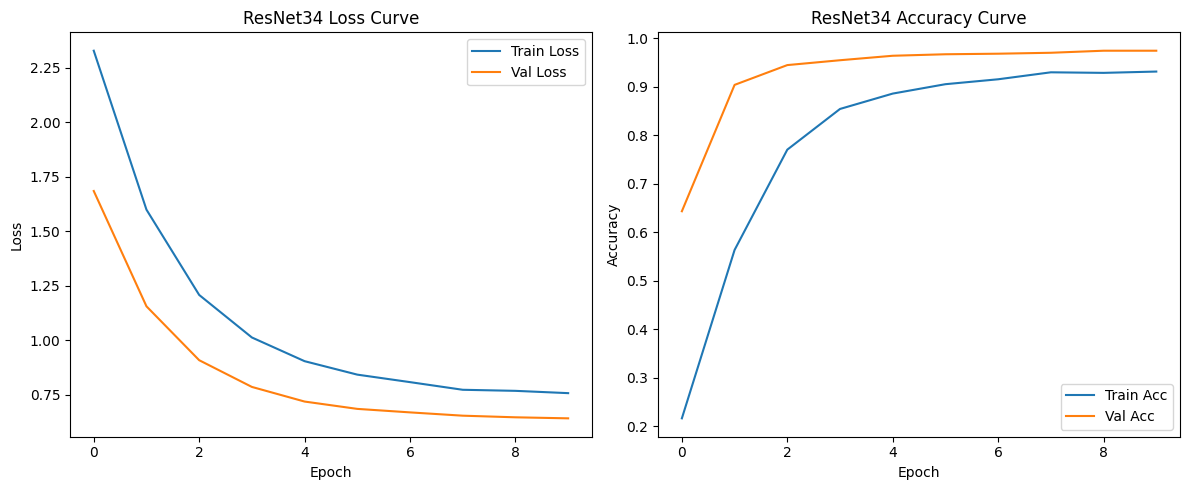

In [17]:
# TODO: 5. Plot the loss and accuracy curves.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_resnet34, label='Train Loss')
plt.plot(val_losses_resnet34, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet34 Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs_resnet34, label='Train Acc')
plt.plot(val_accs_resnet34, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet34 Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Step 3 Train the student model (ResNet18)
1. Set hyperparameters for the distillation process.
2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
3. Load the saved ResNet34 and move the model to selected device.
4. Define the optimizer, loss function, etc.
5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
6. Plot the loss and accuracy curves.

In [18]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


### - TODO: 1. Set hyperparameters for the distillation process.

In [19]:
# TODO: 1. Set hyperparameters for the distillation process.

MAX_EPOCH = 40 
INIT_LR = 0.001
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TEMPERATURE = 5
LOSS_RATIO = 0.5  # Ratio of distillation loss to cross-entropy loss

### - TODO: 2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.


In [20]:
# TODO: 2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.

resnet18 = torchvision.models.resnet18(weights=None)

resnet18.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet18.fc.in_features, num_classes)
)

resnet18 = resnet18.to(device)

### - TODO: 3. Load the saved ResNet34 and move the model to selected device.

In [21]:
# TODO: 3. Load the saved ResNet34 and move the model to selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

resnet34 = torchvision.models.resnet34(weights=None)
resnet34.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet34.fc.in_features, num_classes)
)
resnet34.load_state_dict(torch.load("../models/resnet34_checkpoint.pkl", map_location=device))
resnet34 = resnet34.to(device)
resnet34.eval()  

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17240\4188290274.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet34.load_state_dict(torch.load("../models/resnet34_che

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### - TODO: 4. Define the optimizer, loss function, etc.

In [22]:
# TODO: 4. Define the optimizer, loss function, etc.

optimizer = torch.optim.Adam(
    resnet18.parameters(),
    lr=INIT_LR,
    weight_decay=5e-5
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=10,
    gamma=0.1
)

### - TODO: 5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.

In [23]:
# TODO: 5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
# Hint: Use the correct loss function for knowledge distillation.
#       Details can be fund in https://docs.pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html.

train_accs_resnet18, train_losses_resnet18, val_accs_resnet18, val_losses_resnet18 = [], [], [], []

best_val_acc = 0.0

# Convert label arrays to torch tensors (if not already)
labels_train_index = torch.tensor(labels_train_index, dtype=torch.long)
labels_val_index = torch.tensor(labels_val_index, dtype=torch.long)

# Create PyTorch dataset and dataloader for training
train_dataset = TensorDataset(tensor_train, labels_train_index)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,      # Shuffle data for each epoch
    num_workers=4,     # Use 4 worker processes for data loading
    pin_memory=True    # Pin memory for faster GPU transfer
)

for epoch in range(MAX_EPOCH):
    print("-" * 20)
    print(f"Epoch {epoch+1}/{MAX_EPOCH}")
    print("-" * 10)

    # ---------- Train ----------
    resnet18.train()  # Set model to training mode
    train_loss, train_corrects = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to device (CPU/GPU)
        optimizer.zero_grad()  # Clear gradients from previous step

        # Student output (ResNet18)
        outputs_student = resnet18(inputs)
        # Teacher output (ResNet34, no grad)
        with torch.no_grad():
            outputs_teacher = resnet34(inputs)

        # Cross-entropy loss: student vs. ground truth labels
        loss_ce = F.cross_entropy(outputs_student, labels)
        # Distillation loss: student vs. teacher (soft targets)
        loss_kd = F.kl_div(
            F.log_softmax(outputs_student / TEMPERATURE, dim=1),
            F.softmax(outputs_teacher / TEMPERATURE, dim=1),
            reduction='batchmean'
        ) * (TEMPERATURE ** 2)

        # Total loss: weighted sum of distillation and cross-entropy loss
        loss = LOSS_RATIO * loss_kd + (1 - LOSS_RATIO) * loss_ce

        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        train_loss += loss.item() * inputs.size(0)  # Accumulate loss
        _, preds = torch.max(outputs_student, 1)  # Get predicted class indices
        train_corrects += torch.sum(preds == labels)  # Count correct predictions

    epoch_train_loss = train_loss / len(tensor_train)  # Average training loss
    epoch_train_acc = train_corrects.double() / len(tensor_train)  # Training accuracy

    train_losses_resnet18.append(epoch_train_loss)
    train_accs_resnet18.append(epoch_train_acc.item())

    # ---------- Validation ----------
    resnet18.eval()  # Set model to evaluation mode (disables dropout, etc.)
    val_loss, val_corrects = 0.0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for validation
        for i in range(0, len(tensor_val), BATCH_SIZE):
            inputs = tensor_val[i:i+BATCH_SIZE].to(device)
            labels = labels_val_index[i:i+BATCH_SIZE].to(device)

            outputs = resnet18(inputs)
            loss = F.cross_entropy(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    epoch_val_loss = val_loss / len(tensor_val)  # Average validation loss
    epoch_val_acc = val_corrects.double() / len(tensor_val)  # Validation accuracy

    val_losses_resnet18.append(epoch_val_loss)
    val_accs_resnet18.append(epoch_val_acc.item())

    print(f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f}")
    print(f"Val   Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")

    scheduler.step()  # Update learning rate

    # ---------- Save Best ----------
    is_better = False
    # Save model if validation accuracy improves, or if accuracy is tied but loss improves
    if epoch_val_acc > best_val_acc:
        is_better = True
    elif epoch_val_acc == best_val_acc and epoch_val_loss < best_val_loss:
        is_better = True

    if is_better:
        best_val_acc = epoch_val_acc
        best_val_loss = epoch_val_loss  
        torch.save(resnet18.state_dict(), "../models/resnet18_checkpoint.pkl")  # Save model weights
        print("--- Best model ---")
        print(f"✅ Best model saved at Epoch {epoch+1} | Val Acc: {epoch_val_acc:.4f} | Val Loss: {epoch_val_loss:.4f}")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17240\964994692.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train_index = torch.tensor(labels_train_index, dtype=torch.long)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17240\964994692.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_val_index = torch.tensor(labels_val_index, dtype=torch.long)


--------------------
Epoch 1/40
----------
Train Loss: 1.3942, Acc: 0.5044
Val   Loss: 1.2217, Acc: 0.6154
--- Best model ---
✅ Best model saved at Epoch 1 | Val Acc: 0.6154 | Val Loss: 1.2217
--------------------
Epoch 2/40
----------
Train Loss: 1.0357, Acc: 0.6503
Val   Loss: 1.3615, Acc: 0.5685
--------------------
Epoch 3/40
----------
Train Loss: 0.8652, Acc: 0.7163
Val   Loss: 0.9882, Acc: 0.6838
--- Best model ---
✅ Best model saved at Epoch 3 | Val Acc: 0.6838 | Val Loss: 0.9882
--------------------
Epoch 4/40
----------
Train Loss: 0.7833, Acc: 0.7494
Val   Loss: 0.7836, Acc: 0.7585
--- Best model ---
✅ Best model saved at Epoch 4 | Val Acc: 0.7585 | Val Loss: 0.7836
--------------------
Epoch 5/40
----------
Train Loss: 0.6922, Acc: 0.7832
Val   Loss: 0.8864, Acc: 0.7258
--------------------
Epoch 6/40
----------
Train Loss: 0.6451, Acc: 0.8009
Val   Loss: 0.7163, Acc: 0.7815
--- Best model ---
✅ Best model saved at Epoch 6 | Val Acc: 0.7815 | Val Loss: 0.7163
--------------

### - TODO: 6. Plot the loss and accuracy curves.

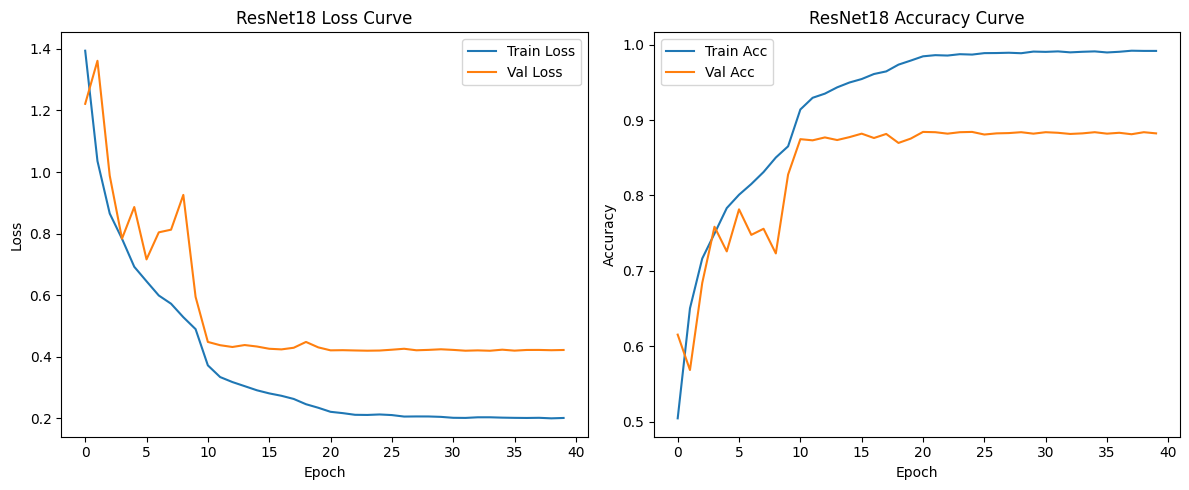

In [24]:
# TODO: 6. Plot the loss and accuracy curves.

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_resnet18, label='Train Loss')
plt.plot(val_losses_resnet18, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet18 Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs_resnet18, label='Train Acc')
plt.plot(val_accs_resnet18, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet18 Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Step 4 Predict labels in the testing set
1. Load the saved ResNet18 and move it to the selected device.
2. Do prediction using the images in the testing set.
3. Write the results into the CSV file for submission.

In [25]:
# TODO: 1. Load the saved ResNet18 and move it to the selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

resnet18 = torchvision.models.resnet18(weights=None)
resnet18.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet18.fc.in_features, num_classes)
)
resnet18.load_state_dict(torch.load("../models/resnet18_checkpoint.pkl", map_location=device))
resnet18 = resnet18.to(device)
resnet18.eval()  


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17240\3694752944.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet18.load_state_dict(torch.load("../models/resnet18_che

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### - TODO: 2. Do prediction using the images in the testing set.

In [26]:
# TODO: 2. Do prediction using the images in the testing set.

predictions = []
with torch.no_grad():  # Disable gradient calculation for inference
    for i in range(0, tensor_test.shape[0], BATCH_SIZE):
        inputs = tensor_test[i:i+BATCH_SIZE].to(device)  # Get a batch of test images and move to device
        outputs = resnet18(inputs)  # Forward pass through the model
        _, preds = torch.max(outputs, 1)  # Get predicted class indices (highest logit)
        predictions.extend(preds.cpu().tolist())  # Store predictions as a list of integers

### - TODO: 3. Write the results into the CSV file for submission.

In [27]:
# TODO: 3. Write the results into the CSV file for submission.
# Hint: The CSV file should be in the format of 'file_name' and 'label'.
#       The submission.csv should look like:
#           file_name,label
#           0.jpg,sunglasses
#           ...

index_to_label = {idx: label for label, idx in label_to_index.items()}
predicted_labels = [index_to_label[idx] for idx in predictions]
file_names = [f"{i}.jpg" for i in range(len(predictions))]


submission_path = "submission.csv"
with open(submission_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["file_name", "label"])
    for fname, lbl in zip(file_names, predicted_labels):
        writer.writerow([fname, lbl])

print(f"✅ Submission file saved to {submission_path}")


✅ Submission file saved to submission.csv
